In [188]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Reduces tensorflow messages.

In [189]:
import warnings
warnings.filterwarnings('ignore')  # Reduces warning messages.

In [190]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout
from keras.callbacks.callbacks import EarlyStopping

In [191]:
import data_handler  # Custom module used to fetch and prepare data from GitHub.

In [192]:
import pandas as pd
import numpy as np

In [193]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller, kpss

In [194]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]  # Adjust plot sizes.

Load the time series data of total infected people.

In [195]:
raw_data = data_handler.load_data()
current_infected = data_handler.calculate_total_infected(raw_data)

# Analysing the time series.

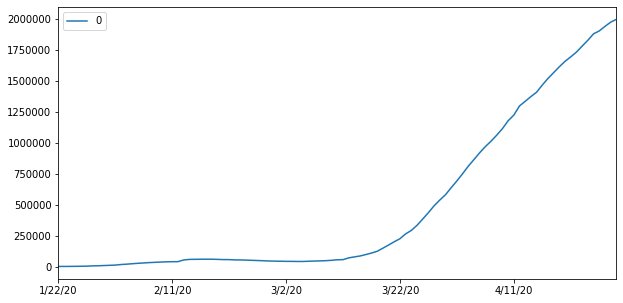

In [196]:
current_infected.plot()

To create accurate forecasts the time series must be stationary. In other words, there must be no trends in the data. From the<br>
plot above it is possible to see that the data is not stationary as the trend seems to be increasing.<br>
There are two statistical tests that can be applied to a time series to check whether it is stationary or not. This is better<br>
than simply 'looking' at the data as it can find (and prove the existence of) useful features in the series.

This function helps print out the results from the following experiments.

In [197]:
def print_results(res, index, row_names):
    formatted_res = pd.Series(res[0:index], index=row_names)
    for key, value in res[index].items():
        formatted_res[f'Critical Value ({key})'] = value
    print(formatted_res)

### First, the Augmented Dickey Fuller (ADF) test.<br>
The null hypothesis for the ADF test is that the time series is not stationary because it has a unit root.<br>
The alternate hypothesis is that there is no unit root in the data making it stationary.<br>
The unit root is a feature in a time  series that causes a trend. This can be removed by differencing the data.<br>
The null hypothesis is assumed to be true until it is proven to be false, i.e. it is assumed that the data is not stationary by default.<br>
To reject the null hypothesis (prove there is no trend) the p-value produced by the test must be less than the Critical Value.<br>
The Critical Value represents how certain the test is of its results, e.g. if the p-value is lest than 0.05 (5%) then we can say that the test is 95% confident that the time series is stationary.

In [198]:
adf_results = adfuller(current_infected)
print("Results for the ADF test:")
print_results(adf_results, 4, ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])

Results for the ADF test:
Test Statistic                 -0.300335
p-value                         0.925457
Lags Used                      10.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


As the p-value is larger than all levels of alpha (0.01, 0.05 and 0.1) this means that the time series has a unit root. In fact<br>
it is possible to multiply the p-value by 100 to see how confident the test is. For example a p-value of 0.973938 means that the<br>
test is 97% confident that the is a unit root (trend) in the data.

### Second, the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test.<br>
The KPSS test complements the ADF test.<br>
Its null hypothesis states that the time series is stationary.<br>
While there alternate hypothesis states that the data has a unit root.<br>
The p-value and the Critical Values work the same ass the ADF test.<br>
However, if the null hypothesis is not rejected, the KPSS shows that the data is 'trend' stationary. This means that it is stationary around a deterministic trend.<br>
For example, a linear trend is present where all values increase over time. If this trend is removed the data will become<br>
stationary.

In [199]:
kpss_results = kpss(current_infected, nlags='auto')
print("Results for the KPSS test:")
print_results(kpss_results, 3, ['Test Statistic', 'p-value', 'Lags Used'])

Results for the KPSS test:
Test Statistic           1.3919
p-value                  0.0100
Lags Used                5.0000
Critical Value (10%)     0.3470
Critical Value (5%)      0.4630
Critical Value (2.5%)    0.5740
Critical Value (1%)      0.7390
dtype: float64


The results show that the null hypothesis is rejected, this means that the unit root is definitely present and that there is no deterministic trend.

Note: the results will be different every time more data is added to the series.

# Making the time series stationary.

As the tests show there is at least one unit root in the data. This can be removed through differencing the time series.<br>
Essentially the difference is taken between each point in the data. As there is no deterministic trend in the data there is no need to use the KPSS test again.

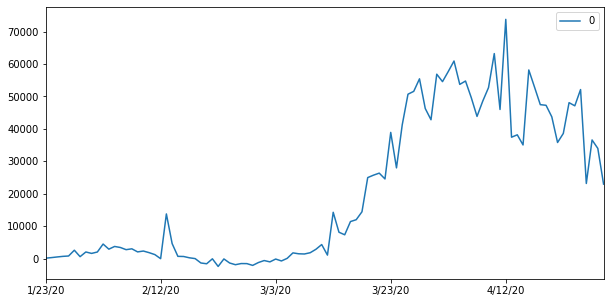

In [200]:
first_differenced = current_infected.diff().dropna()
first_differenced.plot()

Another ADF test on the differenced data shows that there is still a unit root in the data. This means that the data must be differenced again.

In [201]:
adf_results = adfuller(first_differenced)
print("Results for the ADF test:")
print_results(adf_results, 4, ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])

Results for the ADF test:
Test Statistic                 -1.959238
p-value                         0.304727
Lags Used                       9.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


Differencing the data a second time shows us that even though the graph looks line a stationary time series there still is a unit root in the data as the p-value is greater than all alpha values.

Results for the ADF test:
Test Statistic                 -1.121166
p-value                         0.706558
Lags Used                       8.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


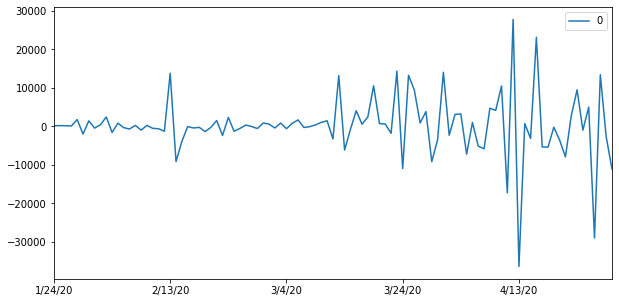

In [202]:
second_differenced = first_differenced.diff().dropna()
second_differenced.plot()
adf_results = adfuller(second_differenced)
print("Results for the ADF test:")
print_results(adf_results, 4, ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])

When differenced a third time the data shows us that there is not more unit roots. The p-value has become so small that there is almost a 100% certainty of it.

Results for the ADF test:
Test Statistic                -9.703654e+00
p-value                        1.055859e-16
Lags Used                      7.000000e+00
Number of Observations Used    8.800000e+01
Critical Value (1%)           -3.506944e+00
Critical Value (5%)           -2.894990e+00
Critical Value (10%)          -2.584615e+00
dtype: float64


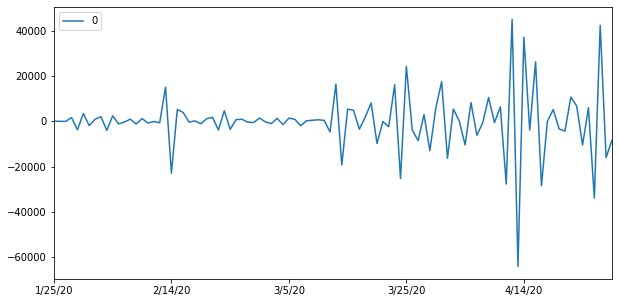

In [203]:
third_differenced = second_differenced.diff().dropna()
third_differenced.plot()
adf_results = adfuller(third_differenced)
print("Results for the ADF test:")
print_results(adf_results, 4, ['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])

# The Gaussian Curve.

It is desirable that the data fits a Gaussian curve as it is easier to model it. The shape of this dataset can be seen by plotting it as a histogram. It is possible to see that the original data has a long right tail. This means that there a many 'rare values' greater than the mean (average). This makes sense when looking back at the original plot where the curve stays horizontal for a while before the number of infected people start to rise.

On the other hand, the data after being differenced three times looks more like a Gaussian distribution (the bell shape). This is because the trends where removed.

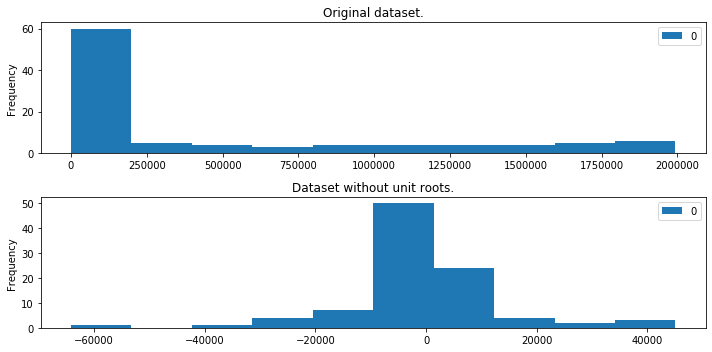

In [204]:
fig, ax = plt.subplots(2, 1)
current_infected.plot(kind='hist', ax=ax[0])
ax[0].set_title("Original dataset.")
third_differenced.plot(kind='hist', ax=ax[1])
ax[1].set_title("Dataset without unit roots.")
fig.tight_layout()

### Data transform.

In [205]:
one_d_ci = [i[0] for i in current_infected.values]  # The boxcox methods require 1 dimensional data.

In [206]:
data1 = boxcox(one_d_ci, -1)    # reciprocal transform.
data2 = boxcox(one_d_ci, -0.5)  # reciprocal square root transform.
data3 = boxcox(one_d_ci, 0)     # log transform.
data4 = boxcox(one_d_ci, 0.5)   # square root transform.

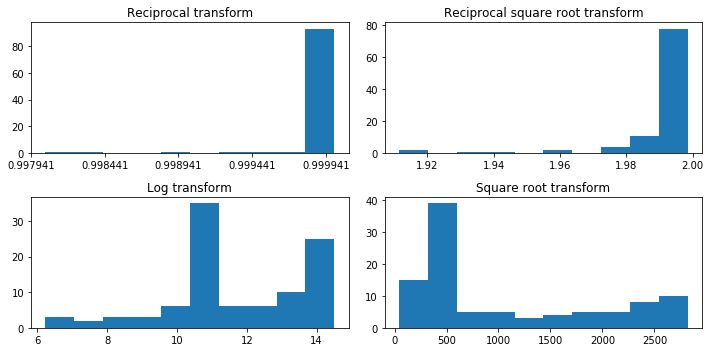

In [207]:
fig, axes = plt.subplots(2, 2)
axes[0,0].hist(data1)
axes[0,0].set_title('Reciprocal transform')
start, end = axes[0,0].get_xlim()  # Prevents the labels on the x-axis from overlapping.
axes[0,0].xaxis.set_ticks(np.arange(start, end, 0.00050))
axes[0,1].hist(data2)
axes[0,1].set_title('Reciprocal square root transform')
axes[1,0].hist(data3)
axes[1,0].set_title('Log transform')
axes[1,1].hist(data4)
axes[1,1].set_title('Square root transform')
fig.tight_layout()

From the graphs above it is possible to see that the method that makes the data look more like a Gaussian distribution is the<br>
log transform. This can be used on the data to 'squash' the values before giving it to the neural network. This is important<br>
because it would take longer to process the larger numbers. Taking the log of the data will reduce training time without<br>
drastically affecting the structure of the data.

# Preparing the data for the Neural Network.

The neural network used in this experiment is the LSTM, a type of RNN. This was chosen as it was designed to handle sequences like a time series.

In [208]:
forecast_horizon = 4   # Number of observations to be used to predict the next event.
train_set_ratio = 0.7  # The size of the training set as a percentage of the data set.

Split the data into train and test sets. This must be done before any transformations to avoid data leakage. Otherwise there might be information about the test set in the train set because of the data transformation applied.<br>
Note: the transformations done before where for the analysis of the time series, now they will be used to actually reshape the data.

In [209]:
train, test = data_handler.split_train_test(current_infected, train_set_ratio)

This helps visualize the train and test data.

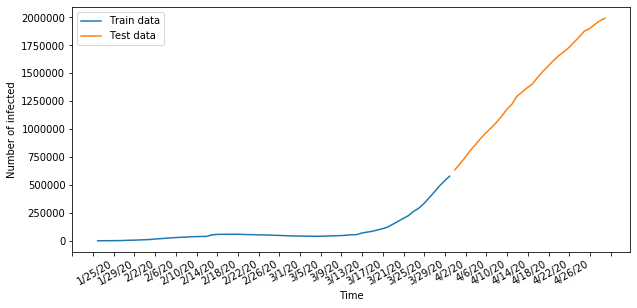

In [210]:
fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_ylabel('Number of infected')
ax.set_xlabel('Time')
ax.legend(['Train data', 'Test data'], loc='best')
# Prevent the x-axis labels from overlapping.
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 4))
fig.autofmt_xdate()

Make the time series data stationary based on what we found before.

In [211]:
train_log, train_diff_one, train_diff_two, stationary_train = data_handler.adjust_data(train)
test_log, test_diff_one, test_diff_two, stationary_test = data_handler.adjust_data(test)

Transform the data into a supervised learning dataset. Essentially the LSTM will use a number of observations<br>
(forecast horizon) to predict the next event in the sequence, e.g. use four days of data to predict the fifth.

In [212]:
supervised_train = data_handler.series_to_supervised(stationary_train, 0, forecast_horizon)
supervised_test = data_handler.series_to_supervised(stationary_test, 0, forecast_horizon)

Create sets for input and output based on the forecast horizon.

In [213]:
x_train, y_train = data_handler.split_horizon(supervised_train, forecast_horizon)
x_test, y_test = data_handler.split_horizon(supervised_test, forecast_horizon)

This part is required by the LSTM as it only takes 3 dimensional input.<br>
Reshape x from [samples, time steps] to [samples, time steps, features]<br>
Where samples = rows and time steps = columns.

In [214]:
features = 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], features)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], features)

# The LSTM

A standard sequential model. One layer after the other.

In [215]:
model = Sequential()

### The input layer.<br>
The LSTM receives the input as an array of size equals to the forecast horizon where each item is an array of size one.<br>
e.g. [[1], [2], [3], [4]]

In [216]:
input_layer = (forecast_horizon, 1)

### The hidden layer.

In [217]:
nodes = 5  #  The number of nodes in the hidden layer represents how 'wide' the network will be.
model.add(LSTM(nodes, input_shape=input_layer))

In [218]:
lstm_activation = "relu"  # The activation function decides how much information flows though the nodes.
model.add(Activation(lstm_activation))

The dropout function selects nodes at random and uses them during one training epoch (iteration). This is applied for each training epoch.<br>
his helps reduce overfitting by making the nodes learn the data instead of relying on other nodes.

In [219]:
rate = 0.1 # The probability of a node being ignored during training, e.g. 10%.
model.add(Dropout(rate))

### The output layer.

In [220]:
out_shape = 1  # The number of outputs the LSTM will produce. Technically the number of nodes in the dense layer.
# It is possible to output the forecasts for the next few days but in this model only one value will be produced.
model.add(Dense(out_shape))

In [221]:
dense_activation = "sigmoid"  # The activation function for the output node works the same as for the hidden layer.
model.add(Activation(dense_activation))

Here the model is told how to learn. The objective of the optimizer is to make the output of the loss function smaller.

In [222]:
loss = "mean_squared_error"
opti = "adam"
model.compile(loss=loss, optimizer=opti)

### Training the LSTM.

This will stop the training if the loss does not change for 50 consecutive epochs.

In [223]:
early_stopping = EarlyStopping(patience=50, restore_best_weights=True)

Here the model is trained. As this was framed as a supervised learning task the LSTM will try to match the input (x_train) to<br>
the output (y_train). One input will pass through the LSTM at a time (batch_size) until all inputs are processed. This will be<br>
done 1000 times (epochs) and in each iteration the network will (hopefully) 'learn' a little more. One fifth of the training<br>
data (0.2) is left out as a validation set for each epoch.

In [224]:
history = model.fit(x_train, y_train, epochs=1000, batch_size=1, verbose=0, callbacks=[early_stopping],
                    validation_split=0.2)

### The test.

Make the predictions. The predictions on the training data are only used to measure the model's performance as it should have<br>
already learnt it.

In [225]:
train_prediction = model.predict(x_train)
test_prediction = model.predict(x_test)

Rescale predictions.

In [226]:
scaled_train_predictions = data_handler.rescale_data(train_prediction, 
                                                     train_diff_one[0], 
                                                     train_diff_two[0], 
                                                     train_log[0], 
                                                     forecast_horizon)
scaled_test_predictions = data_handler.rescale_data(test_prediction, 
                                                    test_diff_one[0], 
                                                    test_diff_two[0], 
                                                    test_log[0], 
                                                    forecast_horizon)

Rescale the answers.

In [227]:
scaled_train = data_handler.rescale_data(y_train, 
                                         train_diff_one[0], 
                                         train_diff_two[0], 
                                         train_log[0], 
                                         forecast_horizon)
scaled_test = data_handler.rescale_data(y_test, 
                                        test_diff_one[0], 
                                        test_diff_two[0], 
                                        test_log[0], 
                                        forecast_horizon)

Functions to calculate the error values using the Root Mean Squared Error and the Root Mean Squared Log Error.

In [228]:
def rmse(target, prediction):
    return np.sqrt(((target - prediction) ** 2).mean())

In [229]:
def rmsle(prediction, target):
    return np.sqrt(((np.log(prediction+1) - np.log(target+1)) ** 2).mean())

Calculate the error values.

In [230]:
train_rmse = rmse(scaled_train, scaled_train_predictions)
test_rmse = rmse(scaled_test, scaled_test_predictions)
train_rmsle = rmsle(scaled_train, scaled_train_predictions)
test_rmsle = rmsle(scaled_test, scaled_test_predictions)

Plot model loss history.

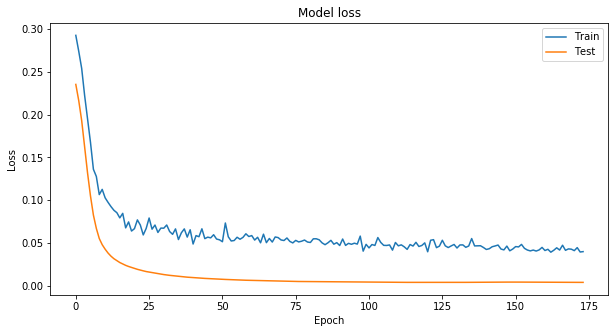

In [231]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(['Train', 'Test'], loc='best')

Some preparation to plot the predictions is needed.

The first sample is lost after each differencing, so the + 2 is required. 

In [232]:
empty_arr = np.empty((forecast_horizon+2, 1))
empty_arr[:] = np.nan
shifted_train = np.concatenate([empty_arr, scaled_train_predictions])
# The test data mus be shifted by 2 empty arrays plus the training data.
empty_arr = np.empty(((forecast_horizon+2)*2+len(scaled_train_predictions), 1))
empty_arr[:] = np.nan
shifted_test = np.concatenate([empty_arr, scaled_test_predictions])

Plot the predictions over the original dataset.

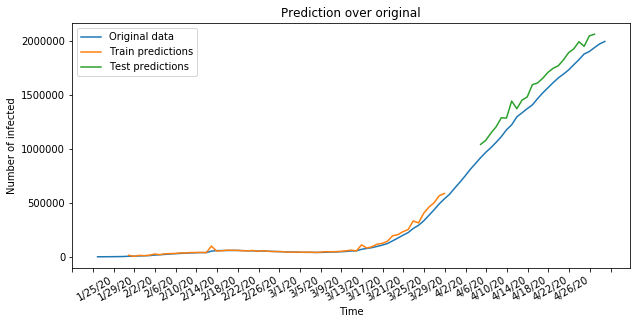

In [233]:
fig, ax = plt.subplots()
ax.plot(current_infected)
ax.plot(shifted_train)
ax.plot(shifted_test)
ax.set_title('Prediction over original')
ax.set_ylabel('Number of infected')
ax.set_xlabel('Time')
ax.legend(['Original data', 'Train predictions', 'Test predictions'], loc='best')
# Prevent the x-axis labels from overlapping.
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 4))
fig.autofmt_xdate()

In [234]:
print(f"RMSE on train: {train_rmse}")
print(f"RMSE on test: {test_rmse}")
print(f"RMSLE on train: {train_rmsle}")
print(f"RMSLE on test: {test_rmsle}")

RMSE on train: 11629.520869650181
RMSE on test: 53105.87770230439
RMSLE on train: 0.18938078671878078
RMSLE on test: 0.03358898530378173
